Guide to download the BRCA dataset and test feature selection methods on it [github](https://github.com/mbonto/XAI_in_progress).

setting.py
- BRCA will be stored in a folder on your computer. Set the absolute path of this folder in the function set_path in setting.py.

Gdc/Data
- Download BRCA: go to the Gdc/Data folder and execute `python get_gdc.py`.
- Discover the content of BRCA through two notebooks `Describe_gdc_tcga_data.ipynb` and `Discover_gdc_tcga_gene_expression_data.ipynb`.
- `Feature_selection_for_BRCA.ipynb` explains how to load BRCA and how to execute a feature selection method from sklearn.




# Preprocessing and Feature selection

We discussed about several preprocessing and feature selection methods. You can update the list with other methods that would be useful to try out.

Preprocessing methods
- Remove genes with low levels. Example: with < 5 counts in > 3 samples (or 60% of samples).
    
Feature selection methods
- Variance
- F test
- Mutual information
- Dimensionality reduction
- Logistic regression
- Regularized logistic regression (LASSO)


# Librairies

In [1]:
import os
import sys
code_path = os.path.split(os.path.split(os.getcwd())[0])[0]
sys.path.append(code_path)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_classif, mutual_info_classif, chi2, VarianceThreshold
from sklearn.metrics import jaccard_score
from setting import *
from utils import *
from loader import *

set_pyplot()

/projects/GraphNEx/anaconda3/envs/GraphNEx/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Path

In [2]:
name = 'BRCA'  
save_path = get_save_path(name, code_path)
data_path = get_data_path(name)

# Useful functions

Sklearn methods are described [here](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection).

In [3]:
# Univariate feature selection
## Without labels
def select_features_with_high_variance(X, threshold):
    """
    Select all features whose variance is higher some threshold.
    """
    alg = VarianceThreshold(threshold=threshold)
    alg.fit(X)
    return alg.variances_

## With labels
def select_features_with_F_test(X, y):
    scores, p = f_classif(X, y)
    # assert (np.argsort(scores) == np.argsort(-p)).all()
    return scores

def select_features_with_mutual_information(X, y): 
    return mutual_info_classif(X, y)

def select_features_with_chi2_test(X, y):
    scores, p = chi2(X, y)
    # assert (np.argsort(scores) == np.argsort(-p)).all()
    return scores

# Dataset

In [4]:
# Normalisation of the data
# We assume that the unit of the gene expression is log2(raw count +1).
## If normalize is True, several normalisations are applied to the data.
## 1. The sum of the raw counts per sample is made equal to 10**6.
## 2. The average value of each gene (computed on the training set) is removed from each gene. 
normalize = False

# Load BRCA dataset
X, X_test, y, y_test, n_class, n_feat, class_name, feat_name = load_dataset(data_path, name, normalize)

# For PyTorch only: use load_dataloader to train/test a neural network.
# train_loader, test_loader, n_class, n_feat, class_name, feat_name, transform, n_sample = load_dataloader(data_path, name, device)
# print(f"In our dataset, we have {n_class} classes and {n_sample} examples. Each example contains {n_feat} features.")

In [5]:
print(f"Number of classes: {n_class}.")
print(f"    Classes: {class_name}.")
print(f"Number of genes: {X.shape[1]}.")
print(f"Examples of names: {feat_name[:3]}.")
print(f"Number of training examples: {X.shape[0]}.")
print(f"Number of test examples: {X_test.shape[0]}.")

Number of classes: 2.
    Classes: ['Primary Tumor', 'Solid Tissue Normal'].
Number of genes: 58274.
Examples of names: ['ENSG00000000003.13', 'ENSG00000000005.5', 'ENSG00000000419.11'].
Number of training examples: 726.
Number of test examples: 484.


# Feature selection methods

In [6]:
# Parameter
threshold = 0.1  # for "select_features_with_high_variance" only

# Features ranked by scores by each feature selection method
scores_var = select_features_with_high_variance(X, threshold)
# scores_F = select_features_with_F_test(X, y)
# scores_MI = select_features_with_mutual_information(X, y)
# scores_chi2 = select_features_with_chi2_test(X, y)

In [7]:
# Load the features ranked by IG for all BRCA samples
model_name = "MLP"  # "MLP" or "LR"
set_name = "train"
exp = 1  # exp between 1 and 10
scores_IG = np.load(os.path.join("scores", f"{model_name}_{exp}_{set_name}_avg.npy"))

# Overlap between the various methods

In [8]:
scores1 = scores_IG.copy()
scores2 = scores_var.copy()

order1 = np.argsort(-scores1)
order2 = np.argsort(-scores2)

In [9]:
# Calculate the Jaccard score between two orders
n_args = [1, 10, 100, 1000, 10000]
avg_jaccard_scores = []

for n in n_args:
    set1 = set(order1[:n])
    set2 = set(order2[:n])
    avg_jaccard_scores.append(len(list(set1.intersection(set2))) / n)

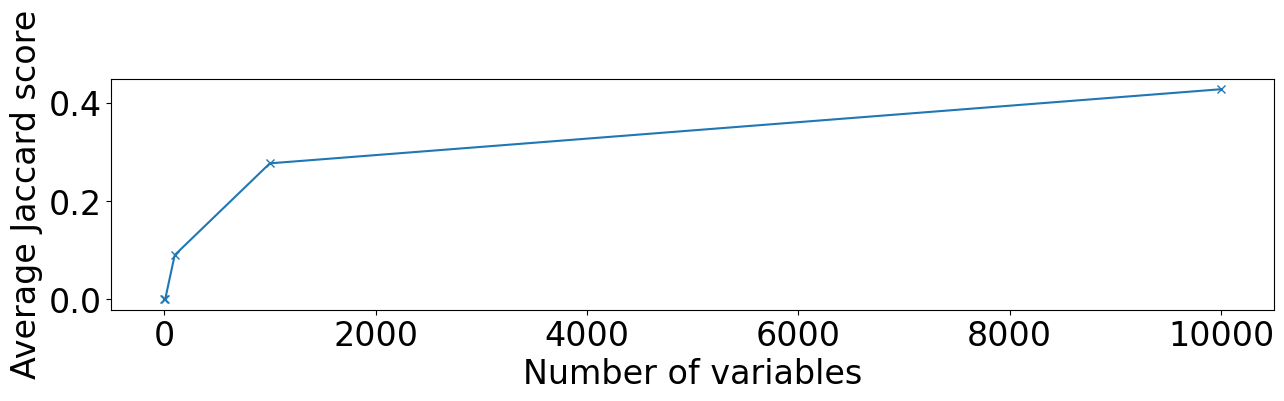

In [10]:
# Show the Jaccard scores
plt.figure(figsize=(15, 3))
plt.plot(n_args, avg_jaccard_scores, 'x-')
plt.xlabel("Number of variables")
plt.ylabel(f"Average Jaccard score")
plt.show()